<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=200>

<CENTER>
</br>
<p><font size="5"> TAF MCE - 2022</span></p>
<p><font size="4">  UE Stochastic dynamic systems </font></p>
<p></p>
<p><font size="5">  Notebook 01: Julia lab - Kalman and particle filters </font></p>
<p><font size="4">  By Kevin Michalewicz </font></p>
</p></br>
</p>
</CENTER>


----------------------------

# <span style="color:#00B8DE">I - Kalman filter (lab 1&2)</span>

Let 

$$
M_t=\sqrt{t}\begin{bmatrix}\cos(2\pi ft)\\ \sin(2\pi ft)\end{bmatrix}
$$

denote the trajectory of a point in a 2D space, with $t=1:T$. The corresponding speed will be calculated using backward finite difference. A noisy version of the trajectory and its speed are observed using a radar. The noise covariance matrix is in the form ${\bf \Sigma}_n=\sigma_n^2\mathbb{I}_4$. We model the system using a simple kinematic model in the form of a state space model where the state vector consists of the position, the speed and the acceleration of the point (as in the lesson). The acceleration is modeled by an $AR(1)$ process: $A_{t+1}=\rho A_t+v_{A,t}$ with ${\bf \Sigma}_{v_A}=\sigma_{v_A}^2\mathbb{I}_2$. We shall write the model 

$$
X_{t+1}={\bf F} X_t +{\bf G} v_t\\
Y_t = {\bf H} X_t+{\bf U} n_t
$$

>- 1) Plot the noiseless and noisy trajectories of position and speed with $T=200$;
>- 2) Give the expressions of ${\bf F}$ and ${\bf H}$ and give the expressions of the matrices ${\bf D}_Q$ and ${\bf D}_R$ in covariance matrices ${\bf Q}=cov[{\bf G} v_t]=σ_v^2 {\bf D}_Q$ and ${\bf R}=cov[{\bf U} n_t]=σ_n^2 {\bf D}_R$;
>- 3) Denoting by  ${\bf K}$, ${\bf P}\_$ and ${\bf P}$ the Kalman gain, and covariance matrices of prediction and filtering errors respectively implement the Kalman filter;
>- 4) Plot the trajectories of position and speed estimated using the Kalman filter. Check the robustness of the estimation with respect to the choice of the parameters of the model;
>- 5) Implement Kalman smoother and check the improvment brought compared to the Kalman filter.

In [503]:
using LinearAlgebra 
using Plots         
using Distributions 

In [544]:
#--------------------------
# PART I : Kalman filter
#--------------------------
# Trajectory synthesis
#---------------------

# Parameters
T = 200
f = 1/T
σn = 0.1 # 1
σVa = 0.01 # 0.1 1

# Defining dimensions
X = zeros(T,2) # position
V = zeros(T,2) # speed

# Initializing 
X[1,1] = cos(2*pi*f)
X[1,2] = sin(2*pi*f)

# Loop to generate trajectories 
for t=2:T
    X[t,1] = sqrt(t) * cos(2*pi*f*t)
    X[t,2] = sqrt(t) * sin(2*pi*f*t)
    
    # backward finite difference
    V[t,1] = X[t,1] - X[t-1,1] 
    V[t,2] = X[t,2] - X[t-1,2] 
end

# Adding noise
X_noisy = X + σn * randn(T,2)
V_noisy = V + σn * randn(T,2);

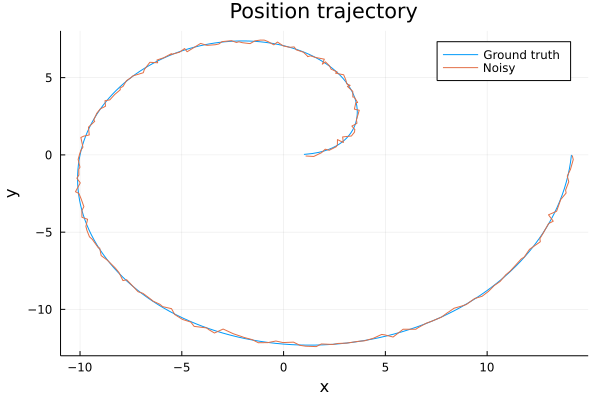

In [545]:
plot(X[:,1], X[:,2], xlabel="x", ylabel="y", label="Ground truth", title="Position trajectory")
plot!(X_noisy[:,1], X_noisy[:,2], label="Noisy")

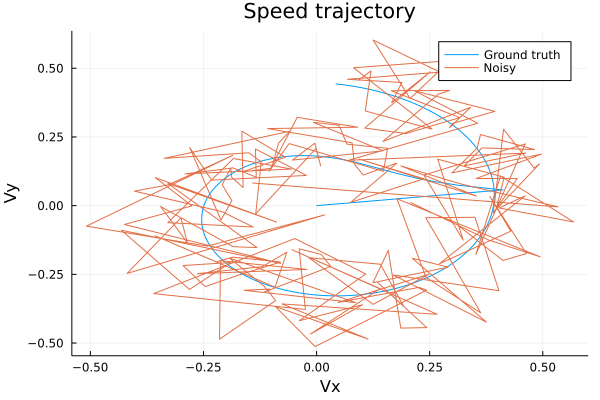

In [546]:
plot(V[:,1], V[:,2], xlabel="Vx", ylabel="Vy", label="Ground truth", title="Speed trajectory")
plot!(V_noisy[:,1], V_noisy[:,2], label="Noisy")

As it was seen during the corresponding lesson, let us define $X_t$ as the position, $V_t$ as the speed and $A_t$ as the acceleration. Knowing the derivative relationships between them, it is possible to write:



$$\begin{bmatrix}X\\ V\\ A\end{bmatrix}_{ t+1} = \begin{bmatrix}\mathbb{I}_2 & \Delta \mathbb{I}_2 & 0\\ 0 & \mathbb{I}_2 & \Delta \mathbb{I}_2\\ 0 & 0 & \rho \mathbb{I}_2\end{bmatrix}\begin{bmatrix}X\\ V\\ A\end{bmatrix}_t + \begin{bmatrix}0\\ 0\\ \mathbb{I}_2\end{bmatrix}v_{A,t}$$ 

and for the observation equation:

$$Y_t = \begin{bmatrix}\mathbb{I}_2 & 0 & 0\\ 0 & \mathbb{I}_2 & 0\end{bmatrix}\begin{bmatrix}X\\ V\\ A\end{bmatrix}_t + n_t$$ 

Therefore

$$F = \begin{bmatrix}\mathbb{I}_2 & \Delta \mathbb{I}_2 & 0\\ 0 & \mathbb{I}_2 & \Delta \mathbb{I}_2\\ 0 & 0 & \rho \mathbb{I}_2\end{bmatrix}$$

$$H = \begin{bmatrix}\mathbb{I}_2 & 0 & 0\\ 0 & \mathbb{I}_2 & 0\end{bmatrix}$$

Also $D_Q \in {\rm I\!R}^{6x6}$ and $D_R \in {\rm I\!R}^{4x4}$ such that:

$$D_Q = \begin{bmatrix}0 & 0 & 0\\ 0 & 0 & 0\\ 0 & 0 & \mathbb{I}_2\end{bmatrix}$$
$$D_R = \begin{bmatrix}\mathbb{I}_2 & 0 \\ 0 & \mathbb{I}_2\end{bmatrix}$$

Note that the sampling interval will be chosen to be $\Delta = 1$.

In [547]:
# State space model
#------------------
Δ = 1 # sampling interval
ρ = 0.4 # 0.01 0.2 0.3 0.5 0.8 # depends on the vehicle 

F = [Matrix(I,2,2) Δ*Matrix(I,2,2) zeros(2,2);
    zeros(2,2) Matrix(I,2,2) Δ*Matrix(I,2,2);
    zeros(2,2) zeros(2,2) ρ*Matrix(I,2,2)]

H = [Matrix(I,2,2) zeros(2,2) zeros(2,2);
    zeros(2,2) Matrix(I,2,2) zeros(2,2)]

Q = σVa^2*[zeros(2,6); zeros(2,6); zeros(2,4) Matrix(I,2,2)]
R = σn^2*Matrix(I,4,4)

# Observation
#------------
Yt = hcat(X_noisy,V_noisy)

# Storage
#--------
# Filtering
#----------
x_filtered = zeros(T,6)
P = zeros(T,6,6)
P[1,:,:] = Matrix(I,6,6)

for t=2:T
    
    x_predicted = F*x_filtered[t-1,:] # predicting
    P_ = F * P[t-1,:,:]*F' + Q # prediction covariance matrix update
    Kt = P_ * H' * inv(H*P_*H'+R) # Kalman gain update
    x_filtered[t,:] = x_predicted + Kt * (Yt[t,:]-H*x_predicted) # filtering
    P[t,:,:] = P_ * (I-Kt*H) # filtering covariance matrix update

end


In [548]:
# Smoothing
#----------
x_filtered_smoothed = zeros(T,6)
x_filtered_smoothed[T,:] = x_filtered[T,:] # initialization with last Kalman filtered element

for t=T-1:-1:2
    Lt = P[t,:,:] * F' * inv(F*P[t,:,:]*F'+Q)
    x_filtered_smoothed[t,:] = x_filtered[t,:] + Lt * (x_filtered_smoothed[t+1,:]-F*x_filtered[t,:])
end

In [549]:
# Graphic outputs
#----------------

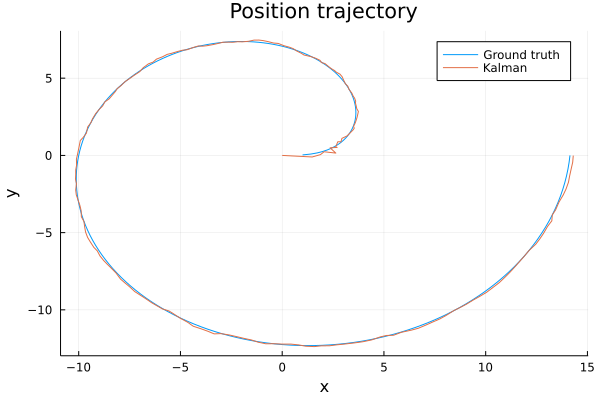

In [550]:
plot(X[:,1], X[:,2], xlabel="x", ylabel="y", label="Ground truth", title="Position trajectory")
plot!(x_filtered[:,1], x_filtered[:,2], label="Kalman")

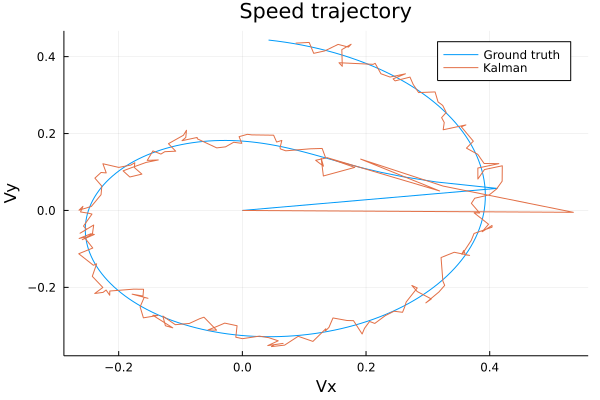

In [551]:
plot(V[:,1], V[:,2], xlabel="Vx", ylabel="Vy", label="Ground truth", title="Speed trajectory")
plot!(x_filtered[:,3], x_filtered[:,4], label="Kalman")

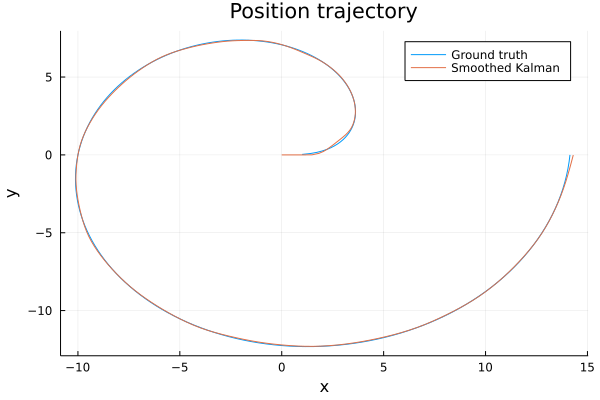

In [552]:
plot(X[:,1], X[:,2], xlabel="x", ylabel="y", label="Ground truth", title="Position trajectory")
plot!(x_filtered_smoothed[:,1], x_filtered_smoothed[:,2], label="Smoothed Kalman")

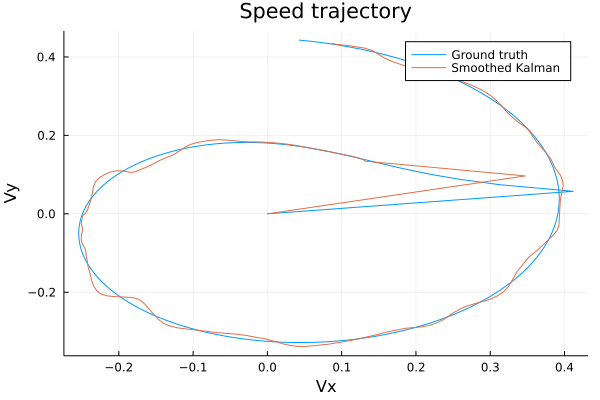

In [553]:
plot(V[:,1], V[:,2], xlabel="Vx", ylabel="Vy", label="Ground truth", title="Speed trajectory")
plot!(x_filtered_smoothed[:,3], x_filtered_smoothed[:,4], label="Smoothed Kalman")

**Comment:** for $\rho$ in $[0.3,0.55]$ the estimation works quite well, except for the speed in the first instants in the standard Kalman filter case. With smoothing the estimation improves. 

For higher values of this parameter the curves turn unstable. If $\rho$ is lower than the mentioned interval, in the smoothed case the position is slightly better estimated but the speed prediction fails much more.

# <span style="color:#00B8DE">II - Particle filtering (lab 3)</span>

We consider the following nonlinear system:

$$
\begin{array}{lll}
{\text{state: }} &x_{t+1} &= 0.5 x_t + \dfrac{25x_t}{1+x_t^2}+8\cos(1,2t)+ v_t,\\
{\text{observation: }} &y_t &= 0.05 x_t^2+ w_t,
\end{array}
$$

with $v_t$ and $w_t$ having respective distributions $\mathcal{N}(0,0.1)$ and $\mathcal{N}(0,1)$.
We want to estimate recursively the state of the system by using a bootstrap particle filter.
We shall use 100 particles and choose $N_{eff}=90$.

>- 1) Generate a trajectory of $y$ for $t=1:T$ with $T=100$. Plot it as well as the corresponding trajectory of x.
What do we note ? For the model studied here what is the main difficulty met in estimating $x$ from $y$?
>- 2) Simulate $N=10^3$ particles using $p(x_t|x_{t-1}^{(i)})$ as an importance distribution and implement the code for generating particles, calculating weights and normalized weights. Implement resampling and apply it when $N_{eff}<90\% N$. What is the resampling rate ?
>- 3) What occurs as the state noise variance increases ? Explanations ?
>- 4) Possibly test the code with other noise distributions

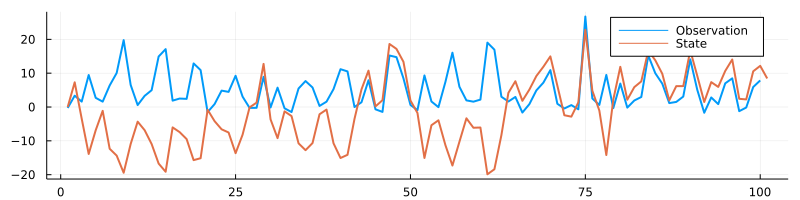

In [541]:
#-----------------------------
# 1) Data model and generation
#-----------------------------
T = 100
σv = √(10) # √(0.1)
σw = 1 # if higher, then p(y|x) is the same for every particle 

# Initializing 
y = zeros(T)
x = zeros(T+1)

for t=1:T
    y[t] = 0.05 * x[t]^2 + σw * randn()
    #y[t] = 0.05 * x[t]^2 + σw * rand(Laplace()) # as if var(w) = 1, then λ = √2 (Laplace parameter)
    x[t+1] = 0.5 * x[t] + (25*x[t])/(1+x[t]^2) + 8 * cos(1.2*t) + σv * randn()
end

# Graphic outputs
#----------------
plot(y, label="Observation", linewidth=2, size=(800,200))
plot!(x, label="State", linewidth=2)


**Comment:** we can point out a quadratic dependence of $y_t$ with respect to $x_t$ in the observation equation of the model. Thus, at zero crossings it is difficult to estimate the state's sign.

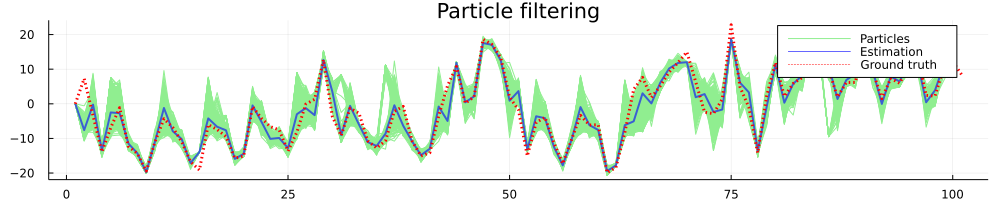

In [542]:
#--------------------------
# 2) Particle sampling
#--------------------------
# Particles initialization
#--------------------------
N = 10^3 # number of particles
Nthr = 0.9 # threshold for resampling
x_candidate = zeros(N,T)
x_tilde = zeros(N,T)

x_candidate[:,1] = randn(N)
w = ones(N)./N
resampling_rate = 0

#--------------------------
# Particles sampling
#--------------------------
for t=2:T
            
    x_candidate[:,t] = 0.5 * x[t-1] + 25*x[t-1]/(1+x[t-1]^2) + 8 * cos(1.2*t) .+ σv * randn(N) # sampling
    w = dot.([pdf(Normal.(0.05*q^2,σw^2),p) for (q,p) in zip(x_candidate[:,t],y[t]*ones(N))], w) # getting new weights
    #w = dot.([pdf(Laplace.(0.05*q^2,σw^2),p) for (q,p) in zip(x_candidate[:,t],y[t]*ones(N))], w) 
    w = w./sum(w) # normalizing 

    if 1/(sum(w.^2)) < Nthr*N
        x_tilde[:,t] = x_candidate[rand(Categorical(w),N),t] # resampling
        resampling_rate += 1/(T-1)
        w = ones(N)./N
    else
        x_tilde[:,t] = x_candidate[:,t]
    end 
end

x_mean_vector = zeros(T)
for t=1:T
    x_mean_vector[t] = mean(x_tilde[:,t])
end

#--------------------------
# Graphic output
#--------------------------
plot(x_tilde[1,:], title="Particle filtering", color=:lightgreen, label="Particles", size=(1000,200))
for n=2:N
    plot!(x_tilde[n,:], color=:lightgreen, label=false)
end
plot!(x_mean_vector, label="Estimation", color=:blue, alpha=0.6, linewidth=2)
plot!(x, label="Ground truth", color=:red, linewidth=3, linestyle=:dot)

In [543]:
print("The resampling rate is ", round(resampling_rate,digits=2))

The resampling rate is 0.93

When $\sigma_v$ increases, more resampling is encountered and a better estimation is obtained (blue curve) - up to reasonable values, experimentally: $var(v)\leq50$ -. If it goes down, all particles behave similarly with a worse estimation. For instance, $\sigma_v^2 = 0.1$ gives a resampling rate of around a $65\%$ and for $\sigma_v^2 = 10$ it is around a $92\%$. Explanation: a low state noise variance makes the different $x_t^{(i)}$ to be similar among them (obtained through sampling), so the weights will tend to be roughly equal. This implies:
- The resampling loop will occasionally be avoided because more often $N_{eff}>90\% N$.
- When resampling occurs, the new particles will not be significantly different from the previous ones. This happens becase, looking at the way the code works, when resampling particles with high weights are multiplicated while the others tend to disappear. But if the weights are similar no distinction is made.
So, when doing the average for each $t$, the estimation is worse than for a higher $\sigma_v$.

A Laplace ($\lambda = \sqrt 2$) distribution was used for $n_t$, keeping the same variance as the one in the gaussian case. The resampling rate remains constant, but the particles offer a smaller dispersion. 